# Using Dice coeff

In [31]:
#starting out with image segmentation
import datetime
import os

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose)

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'
'''
This line of code sets the default colormap for matplotlib plots to "Greys_r",
which is a grayscale colormap in reverse. 
In other words, it sets the color map used to represent image data to a grayscale 
scheme where darker values are represented by lighter shades and vice versa.
'''

'\nThis line of code sets the default colormap for matplotlib plots to "Greys_r",\nwhich is a grayscale colormap in reverse. \nIn other words, it sets the color map used to represent image data to a grayscale \nscheme where darker values are represented by lighter shades and vice versa.\n'

# data preprocessing

In [2]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('data/val_images.tfrecords')

Data is already in `Tf record form`

In [3]:
print(raw_training_dataset)

<TFRecordDatasetV2 shapes: (), types: tf.string>


In [4]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}

In [5]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [6]:
print(str(len(list(parsed_training_dataset)))+" "+str(len(list(parsed_val_dataset))))

234 26


In [7]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    # Decode the raw image data from the example
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    # Set the shape of the decoded image
    image_raw.set_shape([65536])  # 256x256 pixels * 1 channel = 65536
    # Reshape the image data to its original dimensions
    image = tf.reshape(image_raw, [256, 256, 1])

    # Convert the image data to float32 and normalize it
    image = tf.cast(image, tf.float32) * (1. / 1024)

    # Decode the raw label data from the example
    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    # Set the shape of the decoded label
    label_raw.set_shape([65536])  # 256x256 pixels * 1 channel = 65536
    # Reshape the label data to its original dimensions
    label = tf.reshape(label_raw, [256, 256, 1])

    # Return the decoded and processed image and label
    return image, label


In [8]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(
    read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec
#this essentially applies the read and decode to all the image samples

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [9]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [10]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 1), (None, 256, 256, 1)), types: (tf.float32, tf.uint8)>

In [11]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

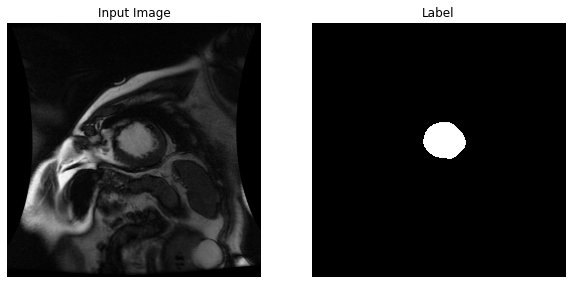

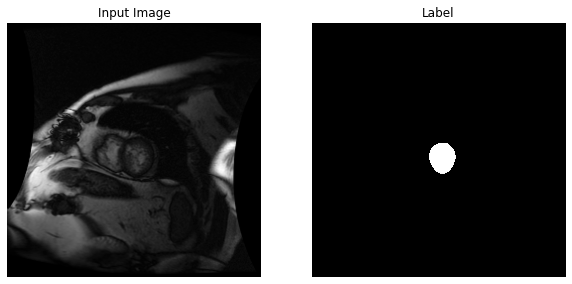

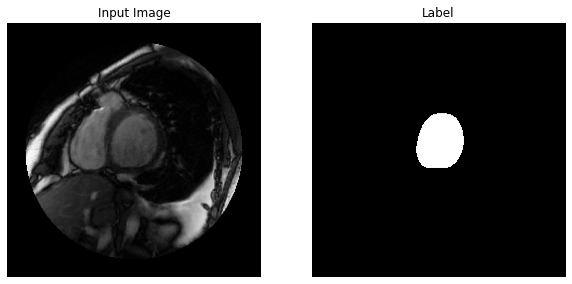

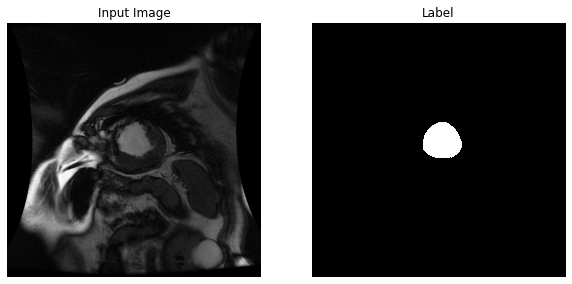

In [12]:
# display an image and label from the training set
for image, label in train.take(4):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

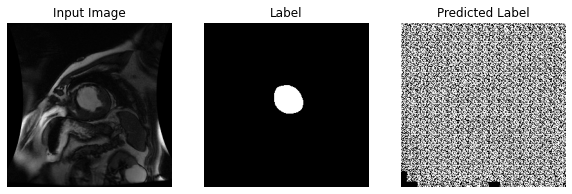

In [18]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])
# show a predection, as an example
show_predictions(test_dataset)

random noise right now no training , just simple funtions to display when we are done

Next, we'll create our own custom [Keras Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback), so that at the end of each epoch, we'll see what our model predicts on our `sample_image`. We'll also set up a [TensorBoard callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) so we can graph our training results.

In [19]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

### Defining Dice Coeff
$$ \frac{2A_{nl}}{A_{n} + A_{l}} $$

In [20]:
def dice_coef(y_true, y_pred, smooth=1):
    indices = K.argmax(y_pred, 3)
    indices = K.reshape(indices, [-1, 256, 256, 1])

    true_cast = y_true
    indices_cast = K.cast(indices, dtype='float32')

    axis = [1, 2, 3]
    intersection = K.sum(true_cast * indices_cast, axis=axis)
    union = K.sum(true_cast, axis=axis) + K.sum(indices_cast, axis=axis)
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)

    return dice

In [21]:
tf.keras.backend.clear_session()

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 128, 128, 100)     2600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 200)       500200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 300)       810300    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 2)         6

significant recuction in trainable parameters which means faster training but also image segmentation since we are using cnn 

Train for 234 steps, validate for 26 steps
Epoch 1/20
228/234 [============================>.] - ETA: 0s - loss: 0.1068 - dice_coef: 0.0249 - accuracy: 0.9703

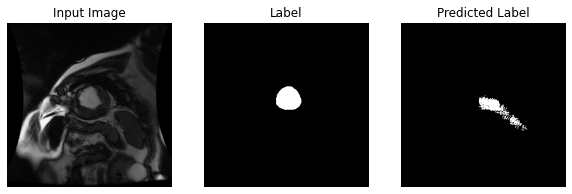


Sample Prediction after epoch 1

234/234 [==============================] - 3s 15ms/step - loss: 0.1060 - dice_coef: 0.0282 - accuracy: 0.9706 - val_loss: 0.0572 - val_dice_coef: 0.4490 - val_accuracy: 0.9834
Epoch 2/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0375 - dice_coef: 0.3425 - accuracy: 0.9873

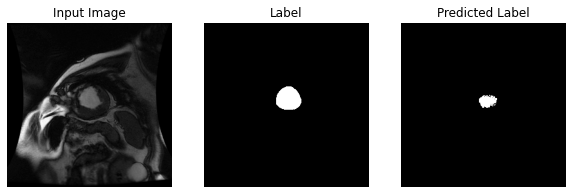


Sample Prediction after epoch 2

234/234 [==============================] - 2s 7ms/step - loss: 0.0373 - dice_coef: 0.3528 - accuracy: 0.9874 - val_loss: 0.0270 - val_dice_coef: 0.5342 - val_accuracy: 0.9903
Epoch 3/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0231 - dice_coef: 0.6036 - accuracy: 0.9915

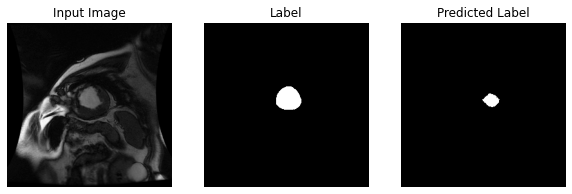


Sample Prediction after epoch 3

234/234 [==============================] - 2s 8ms/step - loss: 0.0231 - dice_coef: 0.6049 - accuracy: 0.9915 - val_loss: 0.0288 - val_dice_coef: 0.4916 - val_accuracy: 0.9895
Epoch 4/20
227/234 [============================>.] - ETA: 0s - loss: 0.0171 - dice_coef: 0.6698 - accuracy: 0.9934

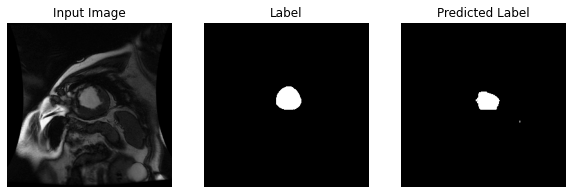


Sample Prediction after epoch 4

234/234 [==============================] - 2s 7ms/step - loss: 0.0172 - dice_coef: 0.6731 - accuracy: 0.9933 - val_loss: 0.0205 - val_dice_coef: 0.6587 - val_accuracy: 0.9926
Epoch 5/20
231/234 [============================>.] - ETA: 0s - loss: 0.0144 - dice_coef: 0.7113 - accuracy: 0.9944

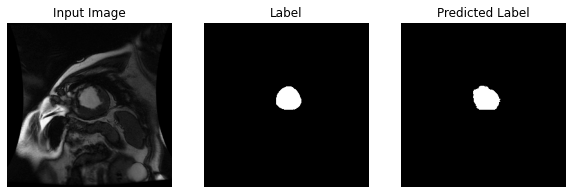


Sample Prediction after epoch 5

234/234 [==============================] - 2s 7ms/step - loss: 0.0144 - dice_coef: 0.7135 - accuracy: 0.9945 - val_loss: 0.0127 - val_dice_coef: 0.7469 - val_accuracy: 0.9951
Epoch 6/20
232/234 [============================>.] - ETA: 0s - loss: 0.0109 - dice_coef: 0.7702 - accuracy: 0.9956

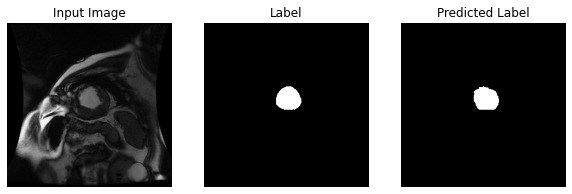


Sample Prediction after epoch 6

234/234 [==============================] - 2s 7ms/step - loss: 0.0109 - dice_coef: 0.7714 - accuracy: 0.9956 - val_loss: 0.0125 - val_dice_coef: 0.7508 - val_accuracy: 0.9953
Epoch 7/20
229/234 [============================>.] - ETA: 0s - loss: 0.0098 - dice_coef: 0.7836 - accuracy: 0.9960

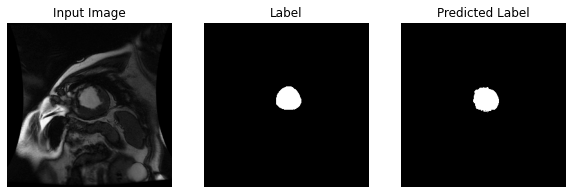


Sample Prediction after epoch 7

234/234 [==============================] - 2s 7ms/step - loss: 0.0098 - dice_coef: 0.7858 - accuracy: 0.9960 - val_loss: 0.0099 - val_dice_coef: 0.7523 - val_accuracy: 0.9960
Epoch 8/20
227/234 [============================>.] - ETA: 0s - loss: 0.0089 - dice_coef: 0.8059 - accuracy: 0.9964

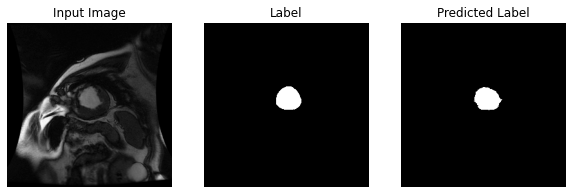


Sample Prediction after epoch 8

234/234 [==============================] - 2s 8ms/step - loss: 0.0088 - dice_coef: 0.8068 - accuracy: 0.9964 - val_loss: 0.0107 - val_dice_coef: 0.7674 - val_accuracy: 0.9959
Epoch 9/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0078 - dice_coef: 0.8191 - accuracy: 0.9968

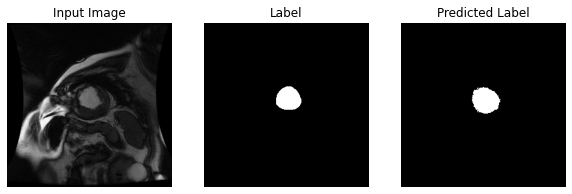


Sample Prediction after epoch 9

234/234 [==============================] - 2s 7ms/step - loss: 0.0079 - dice_coef: 0.8204 - accuracy: 0.9967 - val_loss: 0.0114 - val_dice_coef: 0.7668 - val_accuracy: 0.9955
Epoch 10/20
232/234 [============================>.] - ETA: 0s - loss: 0.0066 - dice_coef: 0.8534 - accuracy: 0.9972

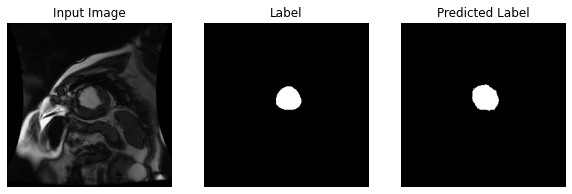


Sample Prediction after epoch 10

234/234 [==============================] - 2s 7ms/step - loss: 0.0066 - dice_coef: 0.8542 - accuracy: 0.9972 - val_loss: 0.0081 - val_dice_coef: 0.8024 - val_accuracy: 0.9969
Epoch 11/20
229/234 [============================>.] - ETA: 0s - loss: 0.0066 - dice_coef: 0.8566 - accuracy: 0.9972

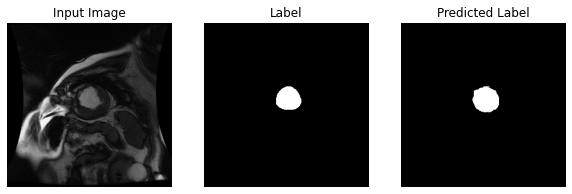


Sample Prediction after epoch 11

234/234 [==============================] - 2s 7ms/step - loss: 0.0066 - dice_coef: 0.8556 - accuracy: 0.9972 - val_loss: 0.0078 - val_dice_coef: 0.7960 - val_accuracy: 0.9970
Epoch 12/20
230/234 [============================>.] - ETA: 0s - loss: 0.0057 - dice_coef: 0.8684 - accuracy: 0.9976

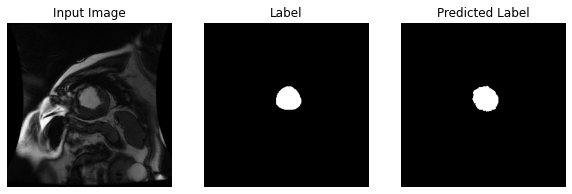


Sample Prediction after epoch 12

234/234 [==============================] - 2s 8ms/step - loss: 0.0057 - dice_coef: 0.8679 - accuracy: 0.9976 - val_loss: 0.0079 - val_dice_coef: 0.7648 - val_accuracy: 0.9968
Epoch 13/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0051 - dice_coef: 0.8836 - accuracy: 0.9978

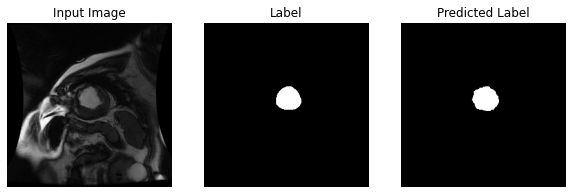


Sample Prediction after epoch 13

234/234 [==============================] - 2s 7ms/step - loss: 0.0052 - dice_coef: 0.8790 - accuracy: 0.9978 - val_loss: 0.0080 - val_dice_coef: 0.7920 - val_accuracy: 0.9970
Epoch 14/20
230/234 [============================>.] - ETA: 0s - loss: 0.0049 - dice_coef: 0.8884 - accuracy: 0.9979

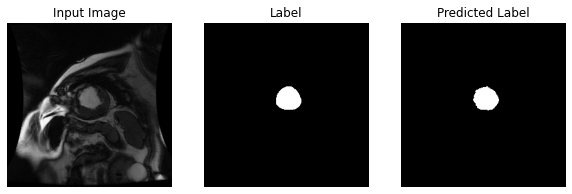


Sample Prediction after epoch 14

234/234 [==============================] - 2s 7ms/step - loss: 0.0049 - dice_coef: 0.8875 - accuracy: 0.9979 - val_loss: 0.0081 - val_dice_coef: 0.8209 - val_accuracy: 0.9970
Epoch 15/20
225/234 [===========================>..] - ETA: 0s - loss: 0.0045 - dice_coef: 0.8899 - accuracy: 0.9980

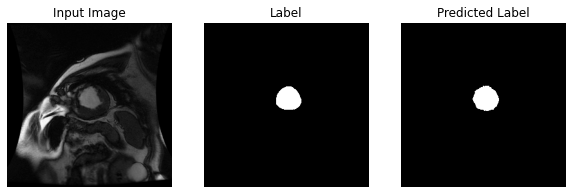


Sample Prediction after epoch 15

234/234 [==============================] - 2s 7ms/step - loss: 0.0045 - dice_coef: 0.8916 - accuracy: 0.9980 - val_loss: 0.0077 - val_dice_coef: 0.8173 - val_accuracy: 0.9972
Epoch 16/20
225/234 [===========================>..] - ETA: 0s - loss: 0.0050 - dice_coef: 0.8860 - accuracy: 0.9979

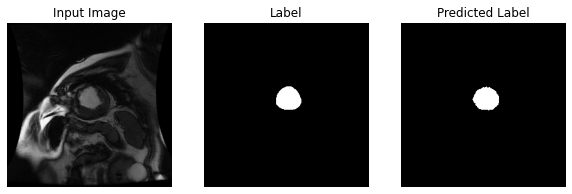


Sample Prediction after epoch 16

234/234 [==============================] - 2s 7ms/step - loss: 0.0049 - dice_coef: 0.8871 - accuracy: 0.9979 - val_loss: 0.0070 - val_dice_coef: 0.8064 - val_accuracy: 0.9974
Epoch 17/20
228/234 [============================>.] - ETA: 0s - loss: 0.0062 - dice_coef: 0.8670 - accuracy: 0.9974

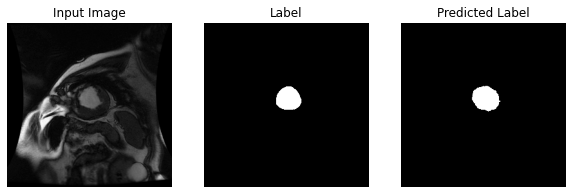


Sample Prediction after epoch 17

234/234 [==============================] - 2s 7ms/step - loss: 0.0061 - dice_coef: 0.8661 - accuracy: 0.9974 - val_loss: 0.0105 - val_dice_coef: 0.8048 - val_accuracy: 0.9969
Epoch 18/20
232/234 [============================>.] - ETA: 0s - loss: 0.0044 - dice_coef: 0.9022 - accuracy: 0.9981

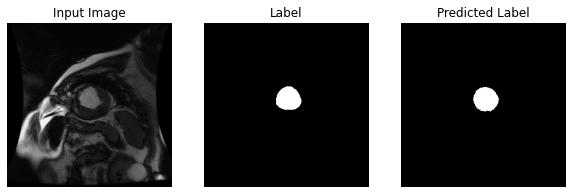


Sample Prediction after epoch 18

234/234 [==============================] - 2s 7ms/step - loss: 0.0044 - dice_coef: 0.9012 - accuracy: 0.9981 - val_loss: 0.0076 - val_dice_coef: 0.8314 - val_accuracy: 0.9973
Epoch 19/20
224/234 [===========================>..] - ETA: 0s - loss: 0.0041 - dice_coef: 0.9051 - accuracy: 0.9982

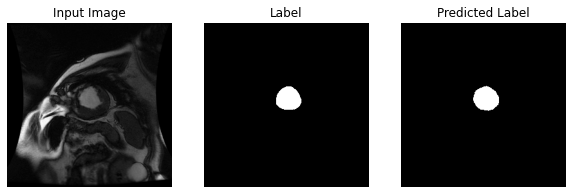


Sample Prediction after epoch 19

234/234 [==============================] - 2s 7ms/step - loss: 0.0041 - dice_coef: 0.9021 - accuracy: 0.9982 - val_loss: 0.0071 - val_dice_coef: 0.8378 - val_accuracy: 0.9973
Epoch 20/20
230/234 [============================>.] - ETA: 0s - loss: 0.0039 - dice_coef: 0.8988 - accuracy: 0.9983

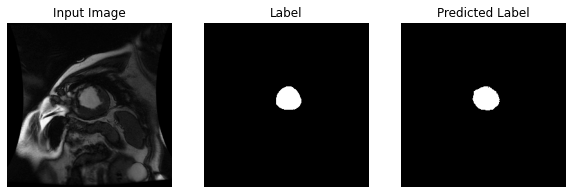


Sample Prediction after epoch 20

234/234 [==============================] - 2s 7ms/step - loss: 0.0039 - dice_coef: 0.8995 - accuracy: 0.9983 - val_loss: 0.0066 - val_dice_coef: 0.8531 - val_accuracy: 0.9974


In [23]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

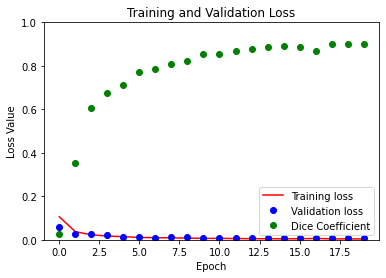

In [24]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


## result:
using a better accuracy meassure showed that there is a scope for improvement the dice only reached about 90% while accuracy is 99.8%

## experiment: using 30 epochs

Train for 234 steps, validate for 26 steps
Epoch 1/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0146 - dice_coef: 0.7094 - accuracy: 0.9943

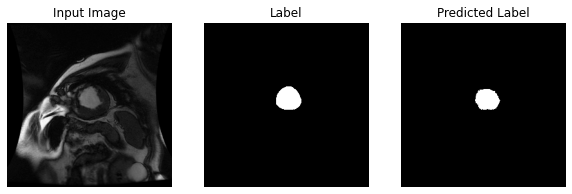


Sample Prediction after epoch 1

234/234 [==============================] - 2s 8ms/step - loss: 0.0147 - dice_coef: 0.7145 - accuracy: 0.9943 - val_loss: 0.0164 - val_dice_coef: 0.7111 - val_accuracy: 0.9939
Epoch 2/30
232/234 [============================>.] - ETA: 0s - loss: 0.0123 - dice_coef: 0.7565 - accuracy: 0.9952

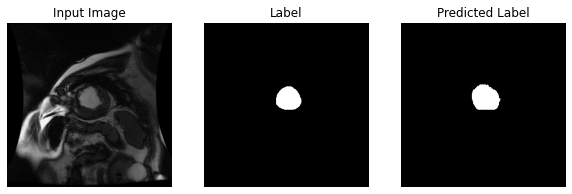


Sample Prediction after epoch 2

234/234 [==============================] - 2s 8ms/step - loss: 0.0122 - dice_coef: 0.7564 - accuracy: 0.9952 - val_loss: 0.0139 - val_dice_coef: 0.7467 - val_accuracy: 0.9947
Epoch 3/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0107 - dice_coef: 0.7805 - accuracy: 0.9957

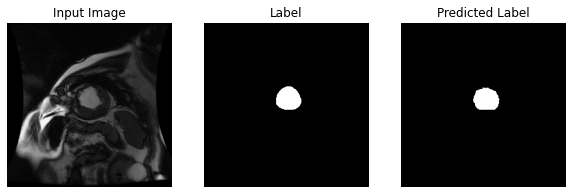


Sample Prediction after epoch 3

234/234 [==============================] - 2s 8ms/step - loss: 0.0107 - dice_coef: 0.7824 - accuracy: 0.9957 - val_loss: 0.0105 - val_dice_coef: 0.7434 - val_accuracy: 0.9958
Epoch 4/30
230/234 [============================>.] - ETA: 0s - loss: 0.0083 - dice_coef: 0.8085 - accuracy: 0.9965

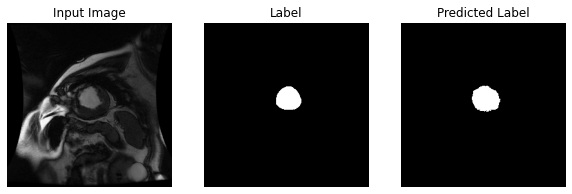


Sample Prediction after epoch 4

234/234 [==============================] - 2s 7ms/step - loss: 0.0083 - dice_coef: 0.8091 - accuracy: 0.9965 - val_loss: 0.0092 - val_dice_coef: 0.7766 - val_accuracy: 0.9963
Epoch 5/30
228/234 [============================>.] - ETA: 0s - loss: 0.0076 - dice_coef: 0.8295 - accuracy: 0.9968

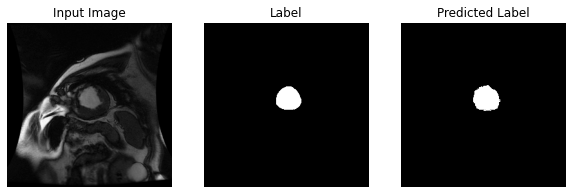


Sample Prediction after epoch 5

234/234 [==============================] - 2s 7ms/step - loss: 0.0075 - dice_coef: 0.8316 - accuracy: 0.9968 - val_loss: 0.0080 - val_dice_coef: 0.7887 - val_accuracy: 0.9967
Epoch 6/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0068 - dice_coef: 0.8486 - accuracy: 0.9971

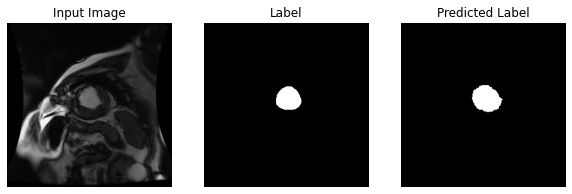


Sample Prediction after epoch 6

234/234 [==============================] - 2s 7ms/step - loss: 0.0068 - dice_coef: 0.8490 - accuracy: 0.9971 - val_loss: 0.0091 - val_dice_coef: 0.7862 - val_accuracy: 0.9964
Epoch 7/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0067 - dice_coef: 0.8587 - accuracy: 0.9972

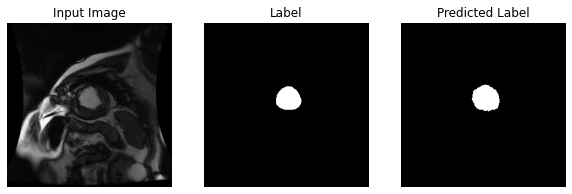


Sample Prediction after epoch 7

234/234 [==============================] - 2s 7ms/step - loss: 0.0067 - dice_coef: 0.8588 - accuracy: 0.9972 - val_loss: 0.0083 - val_dice_coef: 0.7996 - val_accuracy: 0.9967
Epoch 8/30
231/234 [============================>.] - ETA: 0s - loss: 0.0053 - dice_coef: 0.8809 - accuracy: 0.9977

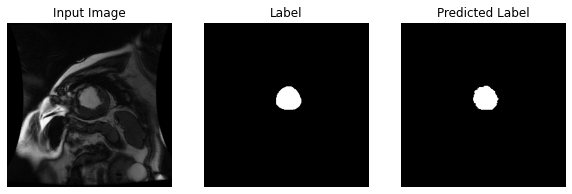


Sample Prediction after epoch 8

234/234 [==============================] - 2s 8ms/step - loss: 0.0053 - dice_coef: 0.8808 - accuracy: 0.9977 - val_loss: 0.0099 - val_dice_coef: 0.7984 - val_accuracy: 0.9966
Epoch 9/30
228/234 [============================>.] - ETA: 0s - loss: 0.0060 - dice_coef: 0.8648 - accuracy: 0.9976

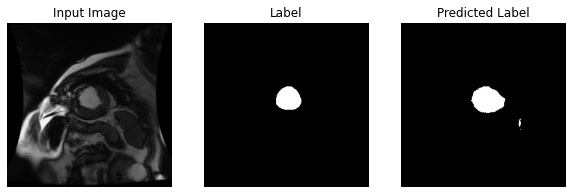


Sample Prediction after epoch 9

234/234 [==============================] - 2s 8ms/step - loss: 0.0060 - dice_coef: 0.8637 - accuracy: 0.9975 - val_loss: 0.0142 - val_dice_coef: 0.7456 - val_accuracy: 0.9944
Epoch 10/30
233/234 [============================>.] - ETA: 0s - loss: 0.0062 - dice_coef: 0.8665 - accuracy: 0.9974

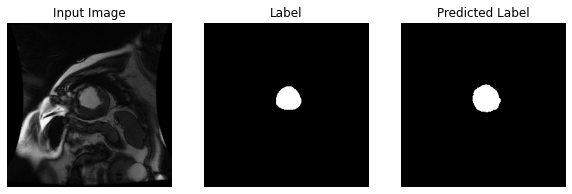


Sample Prediction after epoch 10

234/234 [==============================] - 2s 7ms/step - loss: 0.0062 - dice_coef: 0.8666 - accuracy: 0.9974 - val_loss: 0.0082 - val_dice_coef: 0.8103 - val_accuracy: 0.9969
Epoch 11/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0046 - dice_coef: 0.8890 - accuracy: 0.9980

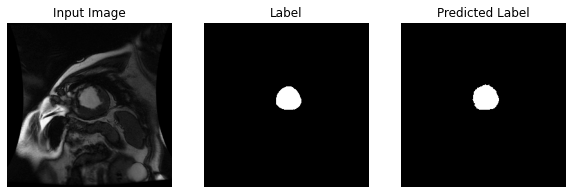


Sample Prediction after epoch 11

234/234 [==============================] - 2s 7ms/step - loss: 0.0046 - dice_coef: 0.8893 - accuracy: 0.9980 - val_loss: 0.0084 - val_dice_coef: 0.8128 - val_accuracy: 0.9969
Epoch 12/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0043 - dice_coef: 0.8918 - accuracy: 0.9981

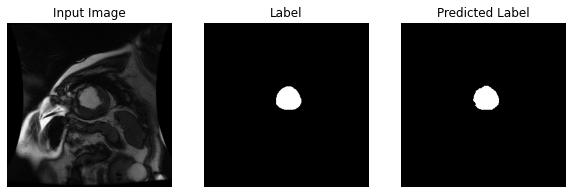


Sample Prediction after epoch 12

234/234 [==============================] - 2s 8ms/step - loss: 0.0043 - dice_coef: 0.8930 - accuracy: 0.9981 - val_loss: 0.0084 - val_dice_coef: 0.8289 - val_accuracy: 0.9970
Epoch 13/30
228/234 [============================>.] - ETA: 0s - loss: 0.0043 - dice_coef: 0.9043 - accuracy: 0.9981

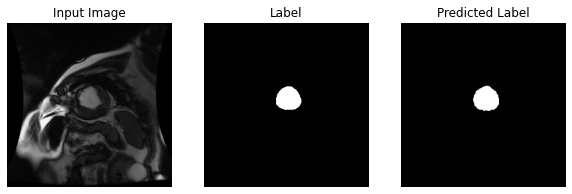


Sample Prediction after epoch 13

234/234 [==============================] - 2s 7ms/step - loss: 0.0043 - dice_coef: 0.9049 - accuracy: 0.9981 - val_loss: 0.0074 - val_dice_coef: 0.8405 - val_accuracy: 0.9973
Epoch 14/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0038 - dice_coef: 0.9101 - accuracy: 0.9984

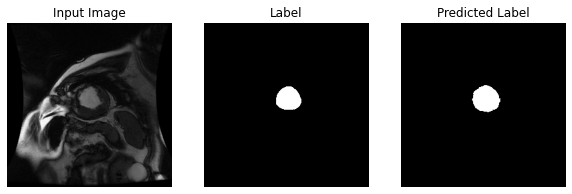


Sample Prediction after epoch 14

234/234 [==============================] - 2s 7ms/step - loss: 0.0038 - dice_coef: 0.9092 - accuracy: 0.9983 - val_loss: 0.0085 - val_dice_coef: 0.8230 - val_accuracy: 0.9968
Epoch 15/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0043 - dice_coef: 0.9057 - accuracy: 0.9981

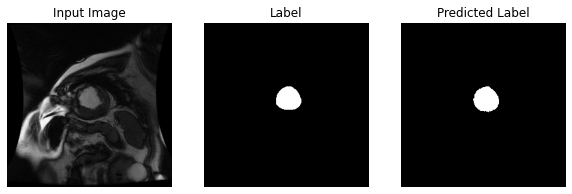


Sample Prediction after epoch 15

234/234 [==============================] - 2s 7ms/step - loss: 0.0043 - dice_coef: 0.9021 - accuracy: 0.9981 - val_loss: 0.0076 - val_dice_coef: 0.8277 - val_accuracy: 0.9972
Epoch 16/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0037 - dice_coef: 0.9084 - accuracy: 0.9984

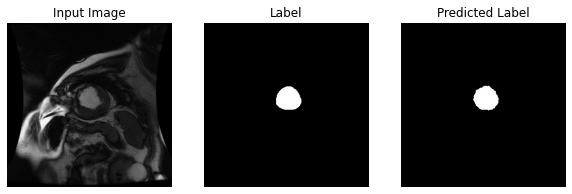


Sample Prediction after epoch 16

234/234 [==============================] - 2s 7ms/step - loss: 0.0037 - dice_coef: 0.9089 - accuracy: 0.9984 - val_loss: 0.0079 - val_dice_coef: 0.8398 - val_accuracy: 0.9972
Epoch 17/30
233/234 [============================>.] - ETA: 0s - loss: 0.0035 - dice_coef: 0.9171 - accuracy: 0.9985

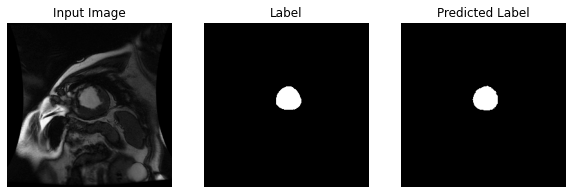


Sample Prediction after epoch 17

234/234 [==============================] - 2s 8ms/step - loss: 0.0035 - dice_coef: 0.9173 - accuracy: 0.9985 - val_loss: 0.0074 - val_dice_coef: 0.8361 - val_accuracy: 0.9973
Epoch 18/30
228/234 [============================>.] - ETA: 0s - loss: 0.0039 - dice_coef: 0.9099 - accuracy: 0.9983

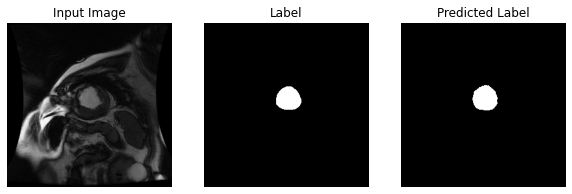


Sample Prediction after epoch 18

234/234 [==============================] - 2s 8ms/step - loss: 0.0039 - dice_coef: 0.9099 - accuracy: 0.9983 - val_loss: 0.0075 - val_dice_coef: 0.8463 - val_accuracy: 0.9975
Epoch 19/30
227/234 [============================>.] - ETA: 0s - loss: 0.0034 - dice_coef: 0.9223 - accuracy: 0.9985

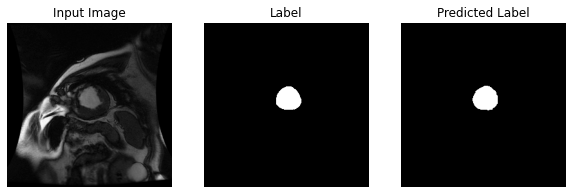


Sample Prediction after epoch 19

234/234 [==============================] - 2s 8ms/step - loss: 0.0034 - dice_coef: 0.9229 - accuracy: 0.9985 - val_loss: 0.0081 - val_dice_coef: 0.8402 - val_accuracy: 0.9973
Epoch 20/30
230/234 [============================>.] - ETA: 0s - loss: 0.0032 - dice_coef: 0.9246 - accuracy: 0.9986

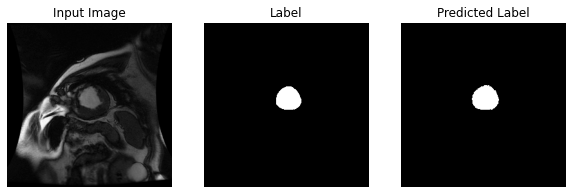


Sample Prediction after epoch 20

234/234 [==============================] - 2s 8ms/step - loss: 0.0032 - dice_coef: 0.9245 - accuracy: 0.9986 - val_loss: 0.0095 - val_dice_coef: 0.8309 - val_accuracy: 0.9969
Epoch 21/30
232/234 [============================>.] - ETA: 0s - loss: 0.0031 - dice_coef: 0.9279 - accuracy: 0.9987

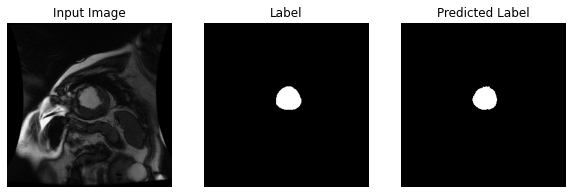


Sample Prediction after epoch 21

234/234 [==============================] - 2s 8ms/step - loss: 0.0031 - dice_coef: 0.9283 - accuracy: 0.9987 - val_loss: 0.0087 - val_dice_coef: 0.8376 - val_accuracy: 0.9973
Epoch 22/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0036 - dice_coef: 0.9188 - accuracy: 0.9984

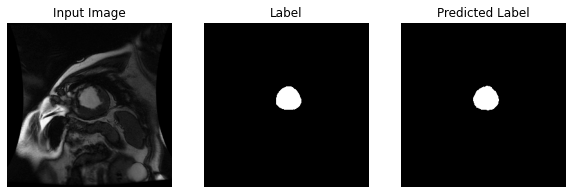


Sample Prediction after epoch 22

234/234 [==============================] - 2s 8ms/step - loss: 0.0036 - dice_coef: 0.9177 - accuracy: 0.9985 - val_loss: 0.0088 - val_dice_coef: 0.8379 - val_accuracy: 0.9973
Epoch 23/30
230/234 [============================>.] - ETA: 0s - loss: 0.0031 - dice_coef: 0.9299 - accuracy: 0.9987

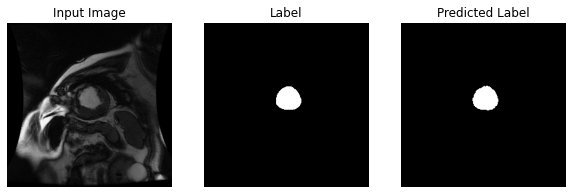


Sample Prediction after epoch 23

234/234 [==============================] - 2s 8ms/step - loss: 0.0032 - dice_coef: 0.9305 - accuracy: 0.9987 - val_loss: 0.0089 - val_dice_coef: 0.8404 - val_accuracy: 0.9973
Epoch 24/30
227/234 [============================>.] - ETA: 0s - loss: 0.0030 - dice_coef: 0.9267 - accuracy: 0.9987

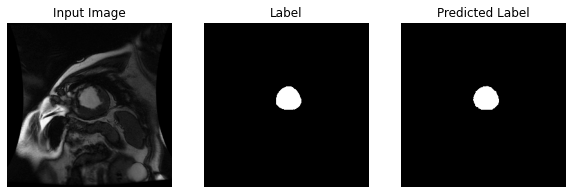


Sample Prediction after epoch 24

234/234 [==============================] - 2s 8ms/step - loss: 0.0030 - dice_coef: 0.9266 - accuracy: 0.9987 - val_loss: 0.0092 - val_dice_coef: 0.8337 - val_accuracy: 0.9972
Epoch 25/30
233/234 [============================>.] - ETA: 0s - loss: 0.0028 - dice_coef: 0.9336 - accuracy: 0.9988

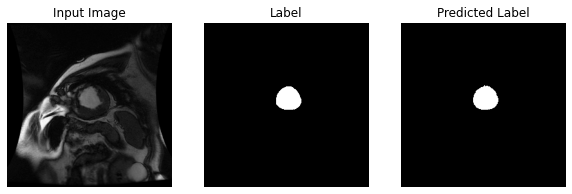


Sample Prediction after epoch 25

234/234 [==============================] - 2s 8ms/step - loss: 0.0028 - dice_coef: 0.9338 - accuracy: 0.9988 - val_loss: 0.0098 - val_dice_coef: 0.8329 - val_accuracy: 0.9971
Epoch 26/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0027 - dice_coef: 0.9406 - accuracy: 0.9988

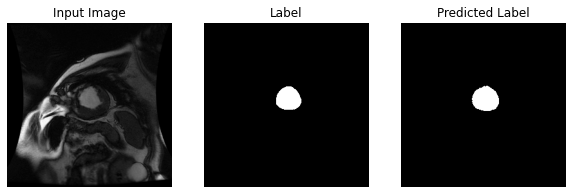


Sample Prediction after epoch 26

234/234 [==============================] - 2s 8ms/step - loss: 0.0027 - dice_coef: 0.9407 - accuracy: 0.9988 - val_loss: 0.0098 - val_dice_coef: 0.8308 - val_accuracy: 0.9970
Epoch 27/30
233/234 [============================>.] - ETA: 0s - loss: 0.0028 - dice_coef: 0.9346 - accuracy: 0.9988

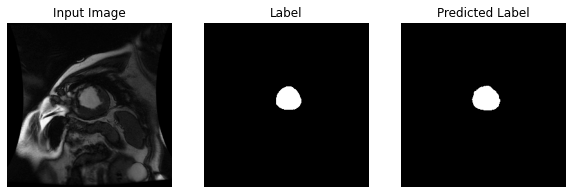


Sample Prediction after epoch 27

234/234 [==============================] - 2s 8ms/step - loss: 0.0028 - dice_coef: 0.9346 - accuracy: 0.9988 - val_loss: 0.0087 - val_dice_coef: 0.8474 - val_accuracy: 0.9971
Epoch 28/30
228/234 [============================>.] - ETA: 0s - loss: 0.0029 - dice_coef: 0.9340 - accuracy: 0.9988

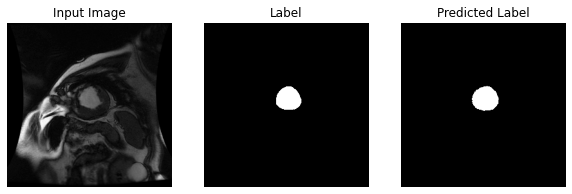


Sample Prediction after epoch 28

234/234 [==============================] - 2s 8ms/step - loss: 0.0029 - dice_coef: 0.9307 - accuracy: 0.9988 - val_loss: 0.0089 - val_dice_coef: 0.8330 - val_accuracy: 0.9972
Epoch 29/30
227/234 [============================>.] - ETA: 0s - loss: 0.0029 - dice_coef: 0.9287 - accuracy: 0.9988

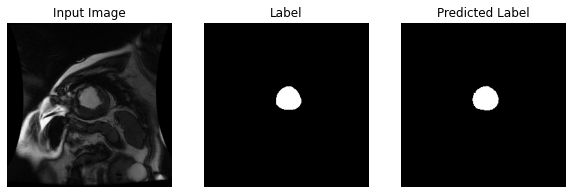


Sample Prediction after epoch 29

234/234 [==============================] - 2s 8ms/step - loss: 0.0029 - dice_coef: 0.9296 - accuracy: 0.9988 - val_loss: 0.0091 - val_dice_coef: 0.8470 - val_accuracy: 0.9973
Epoch 30/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0027 - dice_coef: 0.9377 - accuracy: 0.9988

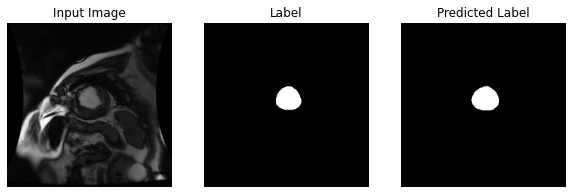


Sample Prediction after epoch 30

234/234 [==============================] - 2s 8ms/step - loss: 0.0027 - dice_coef: 0.9380 - accuracy: 0.9988 - val_loss: 0.0087 - val_dice_coef: 0.8365 - val_accuracy: 0.9972


In [27]:
# setup and run the model
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

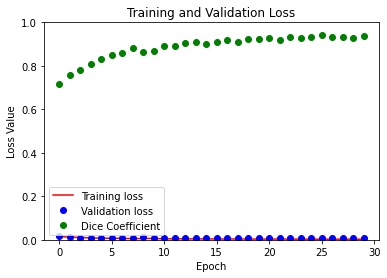

In [28]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


# Implementing U-NET

In [33]:
tf.keras.backend.clear_session()
Ulayers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=200, kernel_size=2, strides=2, padding="same"),#
    Conv2D(filters=200, kernel_size=3, activation=tf.nn.relu, padding="same"),
    Conv2DTranspose(filters=100, kernel_size=2, strides=2, padding="same"),#
    Conv2D(filters=200, kernel_size=3, activation=tf.nn.relu, padding="same"),
    Conv2DTranspose(filters=100, kernel_size=2, strides=2, padding="same"),#
    Conv2D(filters=100, kernel_size=3, activation=tf.nn.relu, padding="same"),
    Conv2D(filters=100, kernel_size=3, activation=tf.nn.relu, padding="same"),
    Conv2D(filters=2, kernel_size=1, activation=tf.nn.relu, padding="same")
]

In [34]:

model = tf.keras.models.Sequential(layers)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[dice_coef,'accuracy'])

Train for 234 steps, validate for 26 steps
Epoch 1/20
231/234 [============================>.] - ETA: 0s - loss: 0.0028 - dice_coef: 0.9336 - accuracy: 0.9988

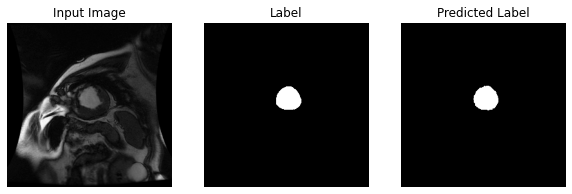


Sample Prediction after epoch 1

234/234 [==============================] - 3s 11ms/step - loss: 0.0028 - dice_coef: 0.9341 - accuracy: 0.9988 - val_loss: 0.0095 - val_dice_coef: 0.8400 - val_accuracy: 0.9972
Epoch 2/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0031 - dice_coef: 0.9308 - accuracy: 0.9987

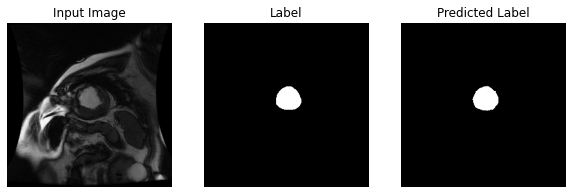


Sample Prediction after epoch 2

234/234 [==============================] - 2s 8ms/step - loss: 0.0032 - dice_coef: 0.9308 - accuracy: 0.9987 - val_loss: 0.0083 - val_dice_coef: 0.8531 - val_accuracy: 0.9973
Epoch 3/20
232/234 [============================>.] - ETA: 0s - loss: 0.0026 - dice_coef: 0.9358 - accuracy: 0.9989

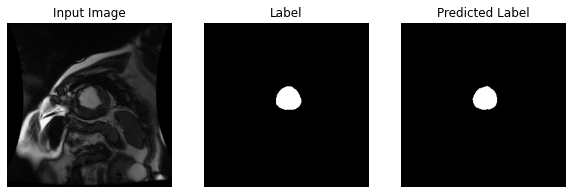


Sample Prediction after epoch 3

234/234 [==============================] - 2s 8ms/step - loss: 0.0026 - dice_coef: 0.9358 - accuracy: 0.9989 - val_loss: 0.0090 - val_dice_coef: 0.8437 - val_accuracy: 0.9974
Epoch 4/20
231/234 [============================>.] - ETA: 0s - loss: 0.0026 - dice_coef: 0.9413 - accuracy: 0.9989

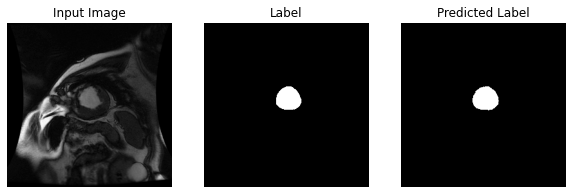


Sample Prediction after epoch 4

234/234 [==============================] - 2s 8ms/step - loss: 0.0026 - dice_coef: 0.9409 - accuracy: 0.9989 - val_loss: 0.0090 - val_dice_coef: 0.8433 - val_accuracy: 0.9973
Epoch 5/20
230/234 [============================>.] - ETA: 0s - loss: 0.0023 - dice_coef: 0.9455 - accuracy: 0.9990

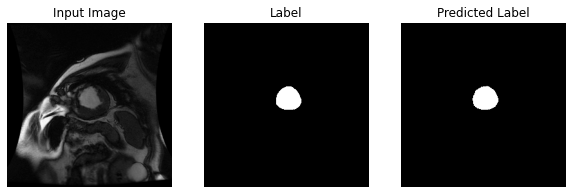


Sample Prediction after epoch 5

234/234 [==============================] - 2s 8ms/step - loss: 0.0023 - dice_coef: 0.9460 - accuracy: 0.9990 - val_loss: 0.0085 - val_dice_coef: 0.8458 - val_accuracy: 0.9974
Epoch 6/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0023 - dice_coef: 0.9459 - accuracy: 0.9990

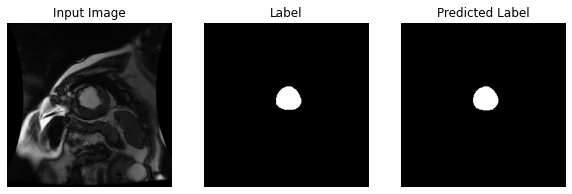


Sample Prediction after epoch 6

234/234 [==============================] - 2s 8ms/step - loss: 0.0023 - dice_coef: 0.9462 - accuracy: 0.9990 - val_loss: 0.0088 - val_dice_coef: 0.8615 - val_accuracy: 0.9974
Epoch 7/20
233/234 [============================>.] - ETA: 0s - loss: 0.0023 - dice_coef: 0.9482 - accuracy: 0.9990

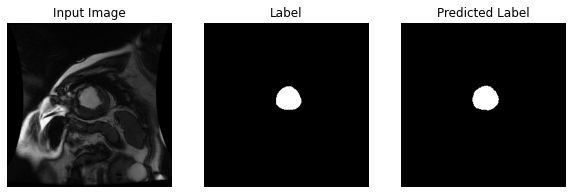


Sample Prediction after epoch 7

234/234 [==============================] - 2s 9ms/step - loss: 0.0023 - dice_coef: 0.9483 - accuracy: 0.9990 - val_loss: 0.0099 - val_dice_coef: 0.8472 - val_accuracy: 0.9971
Epoch 8/20
233/234 [============================>.] - ETA: 0s - loss: 0.0026 - dice_coef: 0.9436 - accuracy: 0.9989

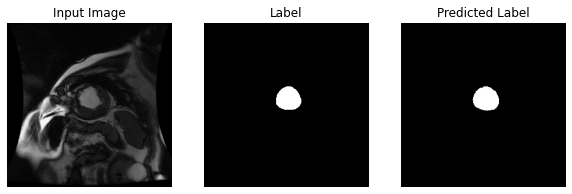


Sample Prediction after epoch 8

234/234 [==============================] - 2s 8ms/step - loss: 0.0025 - dice_coef: 0.9437 - accuracy: 0.9989 - val_loss: 0.0103 - val_dice_coef: 0.8565 - val_accuracy: 0.9972
Epoch 9/20
233/234 [============================>.] - ETA: 0s - loss: 0.0026 - dice_coef: 0.9444 - accuracy: 0.9989

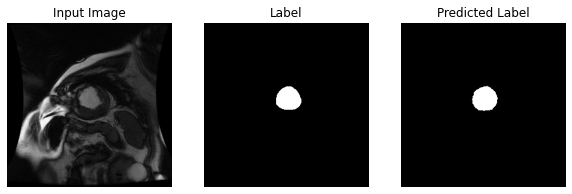


Sample Prediction after epoch 9

234/234 [==============================] - 2s 8ms/step - loss: 0.0026 - dice_coef: 0.9444 - accuracy: 0.9989 - val_loss: 0.0091 - val_dice_coef: 0.8384 - val_accuracy: 0.9974
Epoch 10/20
229/234 [============================>.] - ETA: 0s - loss: 0.0026 - dice_coef: 0.9398 - accuracy: 0.9989

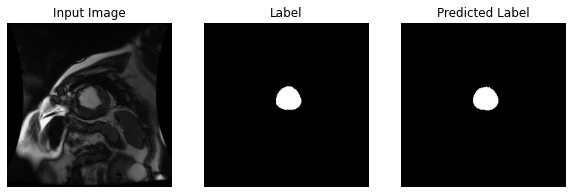


Sample Prediction after epoch 10

234/234 [==============================] - 2s 8ms/step - loss: 0.0026 - dice_coef: 0.9404 - accuracy: 0.9989 - val_loss: 0.0092 - val_dice_coef: 0.8441 - val_accuracy: 0.9975
Epoch 11/20
227/234 [============================>.] - ETA: 0s - loss: 0.0022 - dice_coef: 0.9500 - accuracy: 0.9990

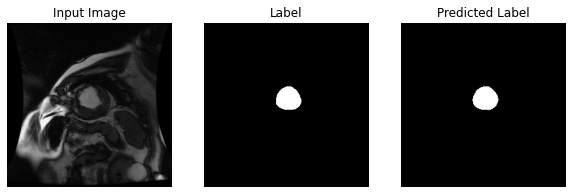


Sample Prediction after epoch 11

234/234 [==============================] - 2s 8ms/step - loss: 0.0022 - dice_coef: 0.9506 - accuracy: 0.9991 - val_loss: 0.0099 - val_dice_coef: 0.8470 - val_accuracy: 0.9975
Epoch 12/20
230/234 [============================>.] - ETA: 0s - loss: 0.0021 - dice_coef: 0.9534 - accuracy: 0.9991

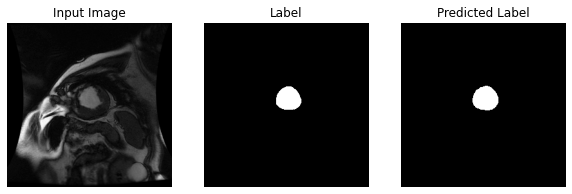


Sample Prediction after epoch 12

234/234 [==============================] - 2s 8ms/step - loss: 0.0021 - dice_coef: 0.9538 - accuracy: 0.9991 - val_loss: 0.0105 - val_dice_coef: 0.8414 - val_accuracy: 0.9974
Epoch 13/20
229/234 [============================>.] - ETA: 0s - loss: 0.0024 - dice_coef: 0.9423 - accuracy: 0.9990

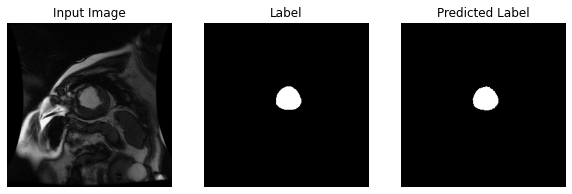


Sample Prediction after epoch 13

234/234 [==============================] - 2s 8ms/step - loss: 0.0024 - dice_coef: 0.9431 - accuracy: 0.9990 - val_loss: 0.0100 - val_dice_coef: 0.8553 - val_accuracy: 0.9972
Epoch 14/20
230/234 [============================>.] - ETA: 0s - loss: 0.0029 - dice_coef: 0.9375 - accuracy: 0.9988

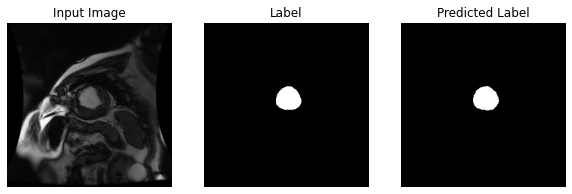


Sample Prediction after epoch 14

234/234 [==============================] - 2s 8ms/step - loss: 0.0029 - dice_coef: 0.9380 - accuracy: 0.9988 - val_loss: 0.0093 - val_dice_coef: 0.8523 - val_accuracy: 0.9975
Epoch 15/20
227/234 [============================>.] - ETA: 0s - loss: 0.0023 - dice_coef: 0.9480 - accuracy: 0.9990

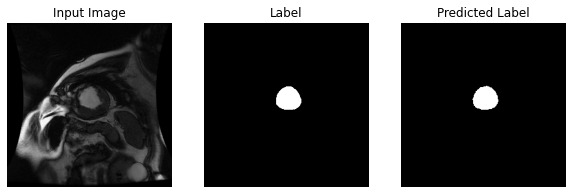


Sample Prediction after epoch 15

234/234 [==============================] - 2s 8ms/step - loss: 0.0023 - dice_coef: 0.9475 - accuracy: 0.9990 - val_loss: 0.0104 - val_dice_coef: 0.8396 - val_accuracy: 0.9973
Epoch 16/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0021 - dice_coef: 0.9524 - accuracy: 0.9991

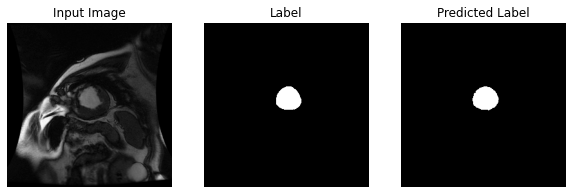


Sample Prediction after epoch 16

234/234 [==============================] - 2s 8ms/step - loss: 0.0021 - dice_coef: 0.9527 - accuracy: 0.9991 - val_loss: 0.0103 - val_dice_coef: 0.8477 - val_accuracy: 0.9974
Epoch 17/20
229/234 [============================>.] - ETA: 0s - loss: 0.0020 - dice_coef: 0.9532 - accuracy: 0.9991

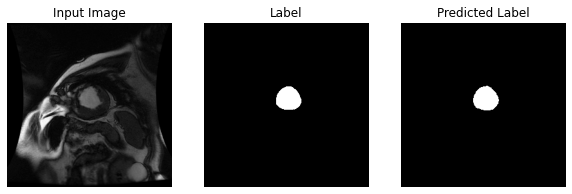


Sample Prediction after epoch 17

234/234 [==============================] - 2s 9ms/step - loss: 0.0020 - dice_coef: 0.9534 - accuracy: 0.9991 - val_loss: 0.0095 - val_dice_coef: 0.8504 - val_accuracy: 0.9974
Epoch 18/20
227/234 [============================>.] - ETA: 0s - loss: 0.0020 - dice_coef: 0.9555 - accuracy: 0.9991

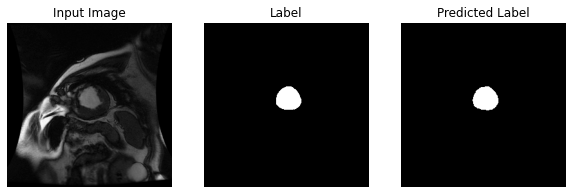


Sample Prediction after epoch 18

234/234 [==============================] - 2s 8ms/step - loss: 0.0020 - dice_coef: 0.9560 - accuracy: 0.9991 - val_loss: 0.0106 - val_dice_coef: 0.8587 - val_accuracy: 0.9974
Epoch 19/20
228/234 [============================>.] - ETA: 0s - loss: 0.0019 - dice_coef: 0.9574 - accuracy: 0.9992

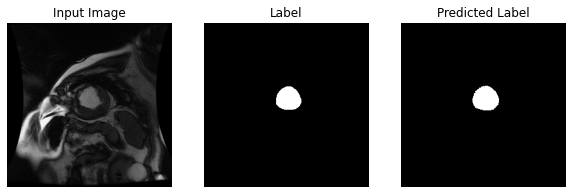


Sample Prediction after epoch 19

234/234 [==============================] - 2s 8ms/step - loss: 0.0019 - dice_coef: 0.9567 - accuracy: 0.9992 - val_loss: 0.0112 - val_dice_coef: 0.8523 - val_accuracy: 0.9974
Epoch 20/20
226/234 [===========================>..] - ETA: 0s - loss: 0.0021 - dice_coef: 0.9551 - accuracy: 0.9991

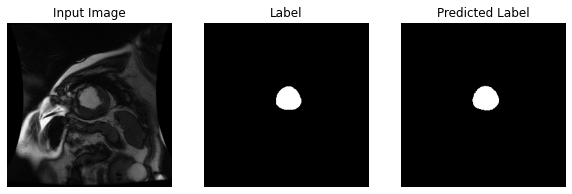


Sample Prediction after epoch 20

234/234 [==============================] - 2s 8ms/step - loss: 0.0021 - dice_coef: 0.9555 - accuracy: 0.9991 - val_loss: 0.0119 - val_dice_coef: 0.8583 - val_accuracy: 0.9972


In [35]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

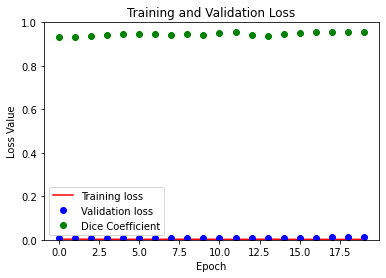

In [36]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [37]:
print(dice[-1])

0.955508


# Result:

using unet we were able to take 90% dice coeff to 95% 

### using 30 epoch

Train for 234 steps, validate for 26 steps
Epoch 1/30
227/234 [============================>.] - ETA: 0s - loss: 0.0020 - dice_coef: 0.9535 - accuracy: 0.9991

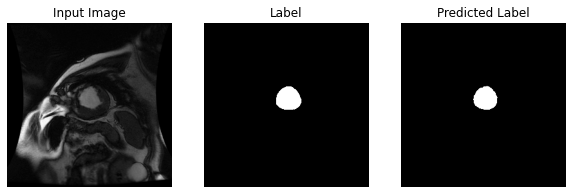


Sample Prediction after epoch 1

234/234 [==============================] - 2s 8ms/step - loss: 0.0020 - dice_coef: 0.9542 - accuracy: 0.9991 - val_loss: 0.0097 - val_dice_coef: 0.8569 - val_accuracy: 0.9975
Epoch 2/30
228/234 [============================>.] - ETA: 0s - loss: 0.0020 - dice_coef: 0.9542 - accuracy: 0.9991

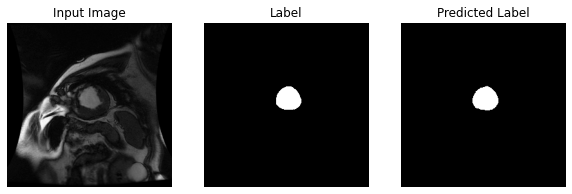


Sample Prediction after epoch 2

234/234 [==============================] - 2s 8ms/step - loss: 0.0020 - dice_coef: 0.9543 - accuracy: 0.9991 - val_loss: 0.0095 - val_dice_coef: 0.8599 - val_accuracy: 0.9975
Epoch 3/30
232/234 [============================>.] - ETA: 0s - loss: 0.0019 - dice_coef: 0.9582 - accuracy: 0.9992

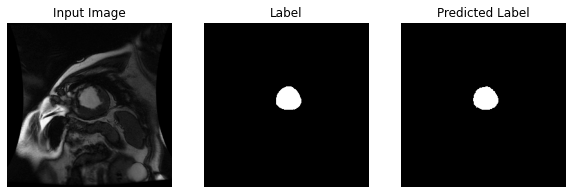


Sample Prediction after epoch 3

234/234 [==============================] - 2s 8ms/step - loss: 0.0019 - dice_coef: 0.9583 - accuracy: 0.9992 - val_loss: 0.0105 - val_dice_coef: 0.8551 - val_accuracy: 0.9974
Epoch 4/30
232/234 [============================>.] - ETA: 0s - loss: 0.0021 - dice_coef: 0.9516 - accuracy: 0.9991

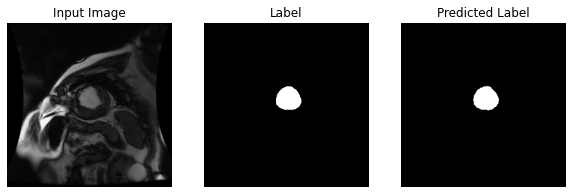


Sample Prediction after epoch 4

234/234 [==============================] - 2s 8ms/step - loss: 0.0021 - dice_coef: 0.9518 - accuracy: 0.9991 - val_loss: 0.0105 - val_dice_coef: 0.8609 - val_accuracy: 0.9972
Epoch 5/30
228/234 [============================>.] - ETA: 0s - loss: 0.0022 - dice_coef: 0.9522 - accuracy: 0.9991

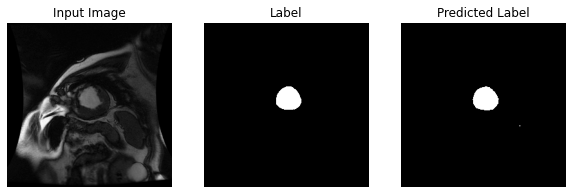


Sample Prediction after epoch 5

234/234 [==============================] - 2s 8ms/step - loss: 0.0022 - dice_coef: 0.9522 - accuracy: 0.9991 - val_loss: 0.0130 - val_dice_coef: 0.8404 - val_accuracy: 0.9972
Epoch 6/30
228/234 [============================>.] - ETA: 0s - loss: 0.0019 - dice_coef: 0.9545 - accuracy: 0.9992

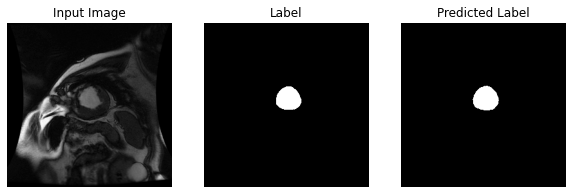


Sample Prediction after epoch 6

234/234 [==============================] - 2s 8ms/step - loss: 0.0019 - dice_coef: 0.9544 - accuracy: 0.9992 - val_loss: 0.0114 - val_dice_coef: 0.8515 - val_accuracy: 0.9973
Epoch 7/30
230/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9577 - accuracy: 0.9992

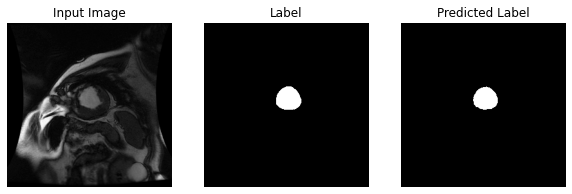


Sample Prediction after epoch 7

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9577 - accuracy: 0.9992 - val_loss: 0.0107 - val_dice_coef: 0.8589 - val_accuracy: 0.9975
Epoch 8/30
232/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9599 - accuracy: 0.9992

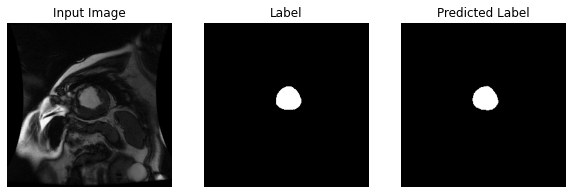


Sample Prediction after epoch 8

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9600 - accuracy: 0.9992 - val_loss: 0.0102 - val_dice_coef: 0.8499 - val_accuracy: 0.9975
Epoch 9/30
228/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9592 - accuracy: 0.9992

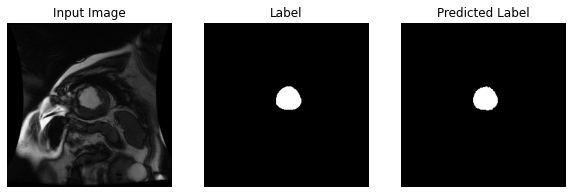


Sample Prediction after epoch 9

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9591 - accuracy: 0.9992 - val_loss: 0.0109 - val_dice_coef: 0.8535 - val_accuracy: 0.9975
Epoch 10/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0019 - dice_coef: 0.9560 - accuracy: 0.9992

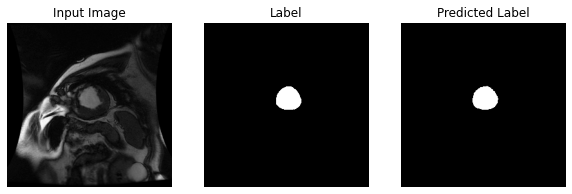


Sample Prediction after epoch 10

234/234 [==============================] - 2s 8ms/step - loss: 0.0019 - dice_coef: 0.9560 - accuracy: 0.9992 - val_loss: 0.0093 - val_dice_coef: 0.8658 - val_accuracy: 0.9975
Epoch 11/30
232/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9564 - accuracy: 0.9992

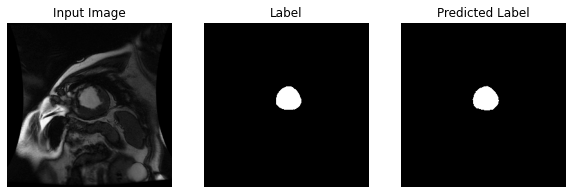


Sample Prediction after epoch 11

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9566 - accuracy: 0.9992 - val_loss: 0.0108 - val_dice_coef: 0.8639 - val_accuracy: 0.9975
Epoch 12/30
229/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9614 - accuracy: 0.9992

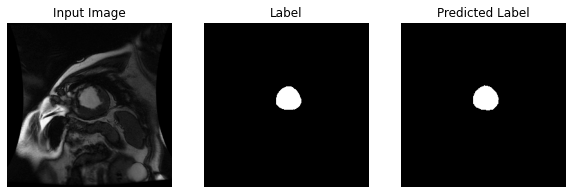


Sample Prediction after epoch 12

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9605 - accuracy: 0.9992 - val_loss: 0.0109 - val_dice_coef: 0.8589 - val_accuracy: 0.9972
Epoch 13/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0019 - dice_coef: 0.9582 - accuracy: 0.9992

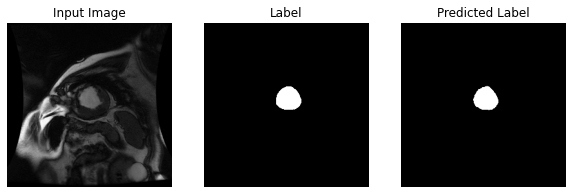


Sample Prediction after epoch 13

234/234 [==============================] - 2s 8ms/step - loss: 0.0019 - dice_coef: 0.9576 - accuracy: 0.9992 - val_loss: 0.0095 - val_dice_coef: 0.8681 - val_accuracy: 0.9975
Epoch 14/30
231/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9603 - accuracy: 0.9992

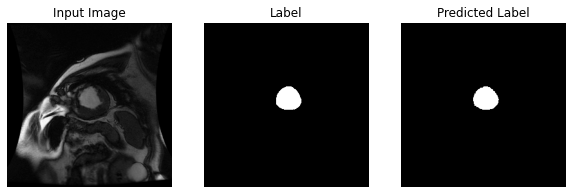


Sample Prediction after epoch 14

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9606 - accuracy: 0.9992 - val_loss: 0.0111 - val_dice_coef: 0.8457 - val_accuracy: 0.9975
Epoch 15/30
231/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9594 - accuracy: 0.9992

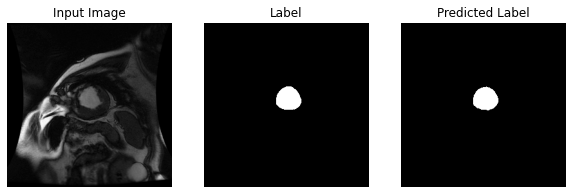


Sample Prediction after epoch 15

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9592 - accuracy: 0.9992 - val_loss: 0.0129 - val_dice_coef: 0.8400 - val_accuracy: 0.9973
Epoch 16/30
233/234 [============================>.] - ETA: 0s - loss: 0.0019 - dice_coef: 0.9596 - accuracy: 0.9992

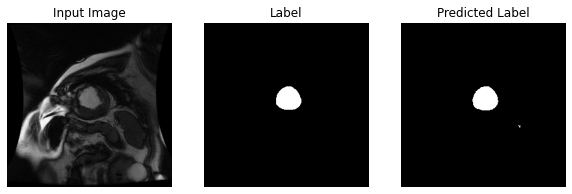


Sample Prediction after epoch 16

234/234 [==============================] - 2s 8ms/step - loss: 0.0019 - dice_coef: 0.9591 - accuracy: 0.9992 - val_loss: 0.0107 - val_dice_coef: 0.8437 - val_accuracy: 0.9975
Epoch 17/30
227/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9612 - accuracy: 0.9992

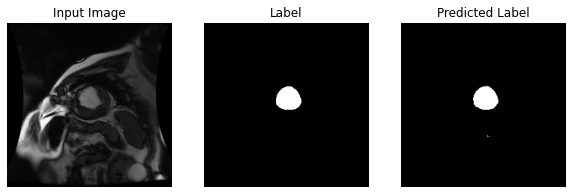


Sample Prediction after epoch 17

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9611 - accuracy: 0.9992 - val_loss: 0.0106 - val_dice_coef: 0.8526 - val_accuracy: 0.9975
Epoch 18/30
225/234 [===========================>..] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9573 - accuracy: 0.9992

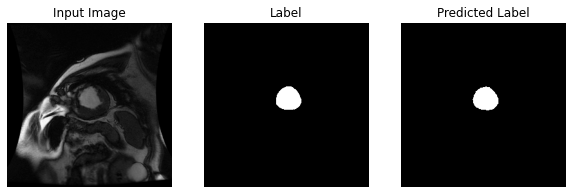


Sample Prediction after epoch 18

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9573 - accuracy: 0.9992 - val_loss: 0.0114 - val_dice_coef: 0.8419 - val_accuracy: 0.9974
Epoch 19/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0017 - dice_coef: 0.9647 - accuracy: 0.9993

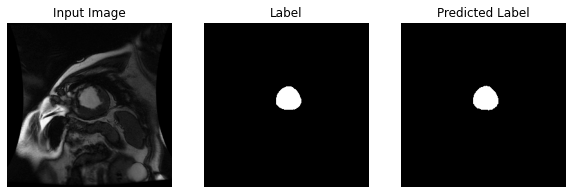


Sample Prediction after epoch 19

234/234 [==============================] - 2s 8ms/step - loss: 0.0017 - dice_coef: 0.9651 - accuracy: 0.9993 - val_loss: 0.0102 - val_dice_coef: 0.8560 - val_accuracy: 0.9976
Epoch 20/30
229/234 [============================>.] - ETA: 0s - loss: 0.0016 - dice_coef: 0.9644 - accuracy: 0.9993

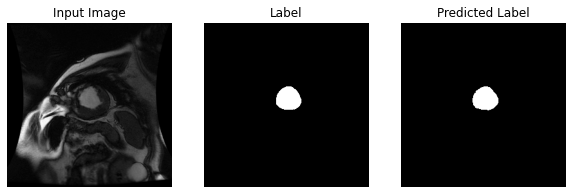


Sample Prediction after epoch 20

234/234 [==============================] - 2s 8ms/step - loss: 0.0016 - dice_coef: 0.9647 - accuracy: 0.9993 - val_loss: 0.0113 - val_dice_coef: 0.8509 - val_accuracy: 0.9975
Epoch 21/30
226/234 [===========================>..] - ETA: 0s - loss: 0.0017 - dice_coef: 0.9631 - accuracy: 0.9993

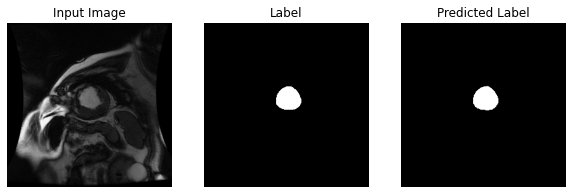


Sample Prediction after epoch 21

234/234 [==============================] - 2s 8ms/step - loss: 0.0017 - dice_coef: 0.9632 - accuracy: 0.9993 - val_loss: 0.0118 - val_dice_coef: 0.8587 - val_accuracy: 0.9974
Epoch 22/30
229/234 [============================>.] - ETA: 0s - loss: 0.0016 - dice_coef: 0.9621 - accuracy: 0.9993

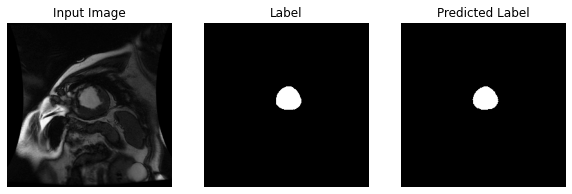


Sample Prediction after epoch 22

234/234 [==============================] - 2s 8ms/step - loss: 0.0016 - dice_coef: 0.9623 - accuracy: 0.9993 - val_loss: 0.0111 - val_dice_coef: 0.8530 - val_accuracy: 0.9975
Epoch 23/30
231/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9605 - accuracy: 0.9992

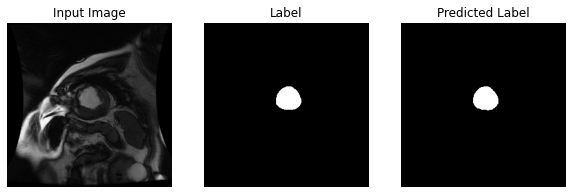


Sample Prediction after epoch 23

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9606 - accuracy: 0.9992 - val_loss: 0.0115 - val_dice_coef: 0.8713 - val_accuracy: 0.9975
Epoch 24/30
229/234 [============================>.] - ETA: 0s - loss: 0.0018 - dice_coef: 0.9612 - accuracy: 0.9992

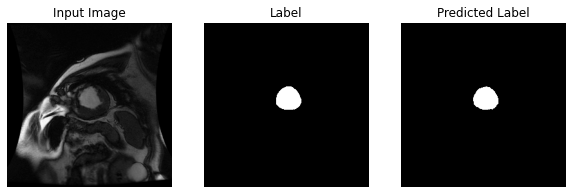


Sample Prediction after epoch 24

234/234 [==============================] - 2s 8ms/step - loss: 0.0018 - dice_coef: 0.9616 - accuracy: 0.9992 - val_loss: 0.0108 - val_dice_coef: 0.8529 - val_accuracy: 0.9975
Epoch 25/30
233/234 [============================>.] - ETA: 0s - loss: 0.0017 - dice_coef: 0.9563 - accuracy: 0.9993

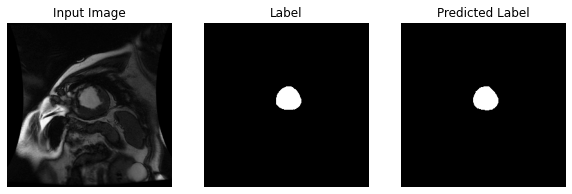


Sample Prediction after epoch 25

234/234 [==============================] - 2s 8ms/step - loss: 0.0017 - dice_coef: 0.9564 - accuracy: 0.9993 - val_loss: 0.0113 - val_dice_coef: 0.8658 - val_accuracy: 0.9974
Epoch 26/30
232/234 [============================>.] - ETA: 0s - loss: 0.0017 - dice_coef: 0.9602 - accuracy: 0.9993

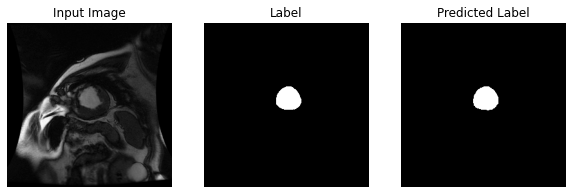


Sample Prediction after epoch 26

234/234 [==============================] - 2s 9ms/step - loss: 0.0017 - dice_coef: 0.9604 - accuracy: 0.9993 - val_loss: 0.0113 - val_dice_coef: 0.8736 - val_accuracy: 0.9976
Epoch 27/30
231/234 [============================>.] - ETA: 0s - loss: 0.0017 - dice_coef: 0.9626 - accuracy: 0.9993

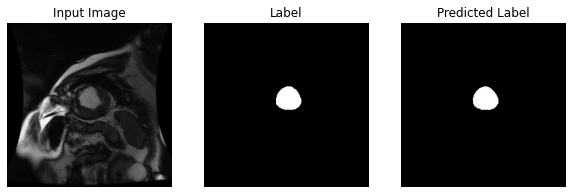


Sample Prediction after epoch 27

234/234 [==============================] - 2s 8ms/step - loss: 0.0017 - dice_coef: 0.9624 - accuracy: 0.9993 - val_loss: 0.0114 - val_dice_coef: 0.8613 - val_accuracy: 0.9975
Epoch 28/30
233/234 [============================>.] - ETA: 0s - loss: 0.0016 - dice_coef: 0.9618 - accuracy: 0.9993

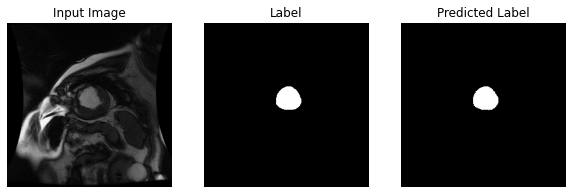


Sample Prediction after epoch 28

234/234 [==============================] - 2s 8ms/step - loss: 0.0016 - dice_coef: 0.9619 - accuracy: 0.9993 - val_loss: 0.0112 - val_dice_coef: 0.8640 - val_accuracy: 0.9975
Epoch 29/30
229/234 [============================>.] - ETA: 0s - loss: 0.0015 - dice_coef: 0.9660 - accuracy: 0.9993

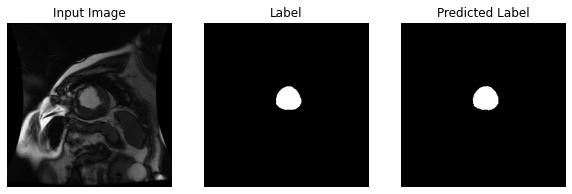


Sample Prediction after epoch 29

234/234 [==============================] - 2s 8ms/step - loss: 0.0015 - dice_coef: 0.9660 - accuracy: 0.9993 - val_loss: 0.0114 - val_dice_coef: 0.8571 - val_accuracy: 0.9976
Epoch 30/30
233/234 [============================>.] - ETA: 0s - loss: 0.0017 - dice_coef: 0.9620 - accuracy: 0.9993

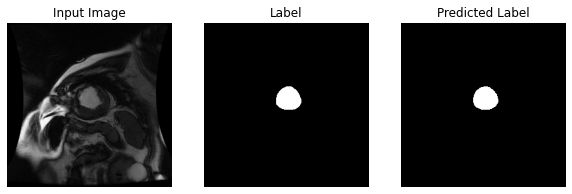


Sample Prediction after epoch 30

234/234 [==============================] - 2s 8ms/step - loss: 0.0017 - dice_coef: 0.9621 - accuracy: 0.9993 - val_loss: 0.0111 - val_dice_coef: 0.8520 - val_accuracy: 0.9976


In [38]:
# setup and run the model
EPOCHS = 30
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

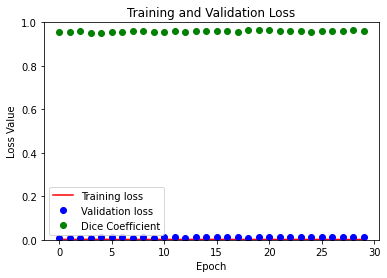

In [39]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
dice = model_history.history['dice_coef']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.plot(epochs, dice, 'go', label='Dice Coefficient')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


# Conclusion:
- using a better coeff for accuracy showed that the model has room for improvement
- using U-Net allowed for much better results using the dice coeff
- using more epochs for simple cnn model showed improvement in performance acc to dice
- No improvement in using more epochs for the U-Net